# Imports

In [ ]:
from collections import Counter, defaultdict
from tqdm.auto import tqdm
from src.data.loader_v2 import DataLoader
from src.features.sentiment import SentimentFeatures
from src.features.concepts import ConceptExtractor
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from src.models.classic import LinearSVMClassifier, LogisticRegressionClassifier
import numpy as np
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2026-01-02 23:30:44.038484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Parameters

In [2]:
MAX_DF_RATIO = 0.3   # Upper threshold (stop-units)
MIN_TERM_FREQ = 10   # Lower threshold (noise)
STD_DEV_Z = 1.96     # 95% Confidence Interval for importance
N_GRAM_RANGE = (1,3)
USE_CONCEPTS = False
NUMBER_CONCEPTS = 1000
LOWER_CONFIDENCE_THRESHOLD = 0.3

# Loading Data-Sets

In [3]:
loader = DataLoader()
train, val, test = loader.load_imdb()

data_sets = [("TRAIN", train), ("VALIDATION", val), ("TEST", test)]

for name, ds in data_sets:
    print(f"\n--- {name} SET (Total: {len(ds)} reviews) ---")
    display(pd.DataFrame(ds[:5]))

Loading IMDb reviews...


I0000 00:00:1767393047.763015   34174 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2026-01-02 23:30:47.966962: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Cleaning 49582 reviews...


2026-01-02 23:30:56.110452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/49582 [00:00<?, ?it/s]


--- TRAIN SET (Total: 29749 reviews) ---


,review,clean_review,clean_bow,sentiment
0,Yet another example of what British cinema can...,Yet another example of what British cinema can...,yet another example of what british cinema can...,1
1,I am probably one of the few who actually read...,I am probably one of the few who actually read...,i am probably one of the few who actually read...,0
2,"believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...",0
3,This soap is worse than bad: it's poisonous. O...,This soap is worse than bad: it's poisonous. O...,this soap is worse than bad: it is poisonous. ...,0
4,"The first time I saw the poster, I was stunned...","The first time I saw the poster, I was stunned...","the first time i saw the poster, i was stunned...",1



--- VALIDATION SET (Total: 9916 reviews) ---


,review,clean_review,clean_bow,sentiment
0,This movie was a stupid piece of crap. Bad eve...,This movie was a stupid piece of crap. Bad eve...,this movie was a stupid piece of crap. bad eve...,0
1,Effect(s) without cause is generally not possi...,Effect(s) without cause is generally not possi...,effect(s) without because is generally not pos...,0
2,It is a story of Siberian village people from ...,It is a story of Siberian village people from ...,it is a story of siberian village people from ...,1
3,Bogdonovich's (mostly) unheralded classic is a...,Bogdonovich's (mostly) unheralded classic is a...,bogdonovich's (mostly) unheralded classic is a...,1
4,"Okay, enough. Every time I think I've seen a f...","Okay, enough. Every time I think I've seen a f...","okay, enough. every time i think i have seen a...",0



--- TEST SET (Total: 9917 reviews) ---


,review,clean_review,clean_bow,sentiment
0,All these reviewers are spot on. I've seen man...,All these reviewers are spot on. I've seen man...,all these reviewers are spot on. i have seen m...,0
1,The third and last part of the Bourne trilogy ...,The third and last part of the Bourne trilogy ...,the third and last part of the bourne trilogy ...,1
2,Love Jones is one of the best movies I've expe...,Love Jones is one of the best movies I've expe...,love jones is one of the best movies i have ex...,1
3,Randolph Scott is heading into Albuquerque to ...,Randolph Scott is heading into Albuquerque to ...,randolph scott is heading into albuquerque to ...,1
4,"The wonderful ""Z"" Channel in Los Angeles showe...","The wonderful ""Z"" Channel in Los Angeles showe...","the wonderful ""z"" channel in los angeles showe...",0


# Filtering-Out Words

## Most Common Words per Label (Stop Words)

Words that occur very frequently across **all labels** generally do not convey sentiment-specific information (e.g., *"this"*, *"the"*, *"is"*). Such terms provide little discriminatory power and can be treated as stop words.

Certain sentiment-related words may also fall into this category. For example, *"good"* appears in both positive and negative contexts and is often non-descriptive on its own (e.g., *"very good"* vs. *"not good"*). As a result, despite its apparent sentiment polarity, it may not meaningfully distinguish between labels and can also be excluded.

In [4]:
df_by_label = defaultdict(Counter)

for row in tqdm(train, desc="Calculating Document Frequencies (JIT)"):
    units = DataLoader.get_ngrams(row['clean_bow'], ngram_range=N_GRAM_RANGE)
    df_by_label[row['sentiment']].update(set(units))

Calculating Document Frequencies (JIT):   0%|          | 0/29749 [00:00<?, ?it/s]

## Document Count per Label

We compute the number of documents associated with each sentiment label.  
This information is later used to normalize word frequencies and to define
label-specific document frequency thresholds.

In [5]:
n_docs_label = Counter(item['sentiment'] for item in train)
print("Document counts by label:", n_docs_label)

Document counts by label: Counter({1: 14930, 0: 14819})


## Intersection

Only words that are **most common in both groups are excluded**. Otherwise, these words are very usefull to distinguish between the labels.

In [6]:
stop_sets = []

for label in df_by_label:
    threshold = n_docs_label[label] * MAX_DF_RATIO
    stop_sets.append({u for u, count in tqdm(df_by_label[label].items(), desc=f"Finding most common words for label {label}") if count > threshold})

stop_units = set.intersection(*stop_sets)
print(f"Identified {len(stop_units)} stop-units.")

Finding most common words for label 1:   0%|          | 0/3310063 [00:00<?, ?it/s]

Finding most common words for label 0:   0%|          | 0/3149839 [00:00<?, ?it/s]

Identified 80 stop-units.


## Least Common Words (Rare-tokens)

These are words that appear only a few times in the dataset. They often include misspellings, proper names, non-existent words, or words in foreign languages (e.g., German).  

In [7]:
tf_counts = Counter()

for item in tqdm(train, desc="Counting units"):
    units = DataLoader.get_ngrams(item['clean_bow'], ngram_range=N_GRAM_RANGE)
    for u in units:
        if u not in stop_units:
            tf_counts[u] += 1

# Filter for units that appear at least MIN_TERM_FREQ times
unique_units = {u for u, count in tqdm(tf_counts.items(), desc="Filtering units") if count >= MIN_TERM_FREQ}
print(f"Total unique units after filtering: {len(unique_units)}")

Counting units (JIT):   0%|          | 0/29749 [00:00<?, ?it/s]

Filtering units:   0%|          | 0/5693007 [00:00<?, ?it/s]

Total unique units after filtering: 179197


# Concepts
Words grouped with embeddings and k-means

In [8]:
if USE_CONCEPTS:
    print("Extracting semantic concepts using SBERT + Clustering...")
    extractor = ConceptExtractor()
    concept_results = extractor.train_concepts(unique_units, n_clusters=NUMBER_CONCEPTS)
    train_map = concept_results['unit_to_cluster']
    cluster_centers = concept_results['cluster_centers']
else:
    print("Using standard Bag-of-Words (Identity Mapping)...")
    train_map = {unit: i for i, unit in enumerate(unique_units)}
    extractor = None

Using standard Bag-of-Words (Identity Mapping)...


In [9]:
for row in tqdm(train, desc="Mapping Train Units"):
    units = DataLoader.get_ngrams(row['clean_bow'], ngram_range=N_GRAM_RANGE)
    # Map to integer IDs and store
    row['concept_ids'] = [train_map[u] for u in units if u in train_map]

Mapping Train Units :   0%|          | 0/29749 [00:00<?, ?it/s]

# Feature selection

In [10]:
# 1. Fit Sentiment Statistics
sf = SentimentFeatures()
sf.fit([item['concept_ids'] for item in train], [item['sentiment'] for item in train])

# 2. Extract Significant Features (Z-Score filtering)
top_pos_ids = set(sf.logodds_per_class[1][sf.logodds_per_class[1]['zscore'] > STD_DEV_Z]['concept'])
top_neg_ids = set(sf.logodds_per_class[0][sf.logodds_per_class[0]['zscore'] > STD_DEV_Z]['concept'])
important_set = top_pos_ids | top_neg_ids

total_concepts = len(sf.concept_list)
important_count = len(important_set)

# 3. Number of "not important" concepts
not_important_count = total_concepts - important_count

print(f"Total concepts processed: {total_concepts}")
print(f"Important concepts (kept): {important_count}")
print(f"Not important concepts (discarded): {not_important_count}")

discard_ratio = (not_important_count / total_concepts) * 100
print(f"Reduction rate: {discard_ratio:.2f}%")

# 4. Filter only important indices
for item in tqdm(train, desc="Filtering Important IDs"):
    item['important_ids'] = [c for c in item['concept_ids'] if c in important_set]

Total concepts processed: 179197
Important concepts (kept): 48323
Not important concepts (discarded): 130874
Reduction rate: 73.03%


Filtering Important IDs:   0%|          | 0/29749 [00:00<?, ?it/s]

In [11]:
for name, ds in data_sets:
    print(f"\n--- {name} SET (Total: {len(ds)} reviews) ---")
    display(pd.DataFrame(ds[:5]))


--- TRAIN SET (Total: 29749 reviews) ---


,review,clean_review,clean_bow,sentiment,concept_ids,important_ids
0,Yet another example of what British cinema can...,Yet another example of what British cinema can...,yet another example of what british cinema can...,1,"[82267, 74701, 139657, 112642, 138470, 38434, ...","[82267, 139657, 112642, 138470, 42520, 164346,..."
1,I am probably one of the few who actually read...,I am probably one of the few who actually read...,i am probably one of the few who actually read...,0,"[97751, 140468, 48961, 101526, 14923, 10606, 3...","[97751, 140468, 48961, 101526, 14923, 35557, 9..."
2,"believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...",0,"[172064, 171312, 122318, 52565, 79803, 18814, ...","[172064, 171312, 122318, 52565, 79803, 54548, ..."
3,This soap is worse than bad: it's poisonous. O...,This soap is worse than bad: it's poisonous. O...,this soap is worse than bad: it is poisonous. ...,0,"[90672, 171312, 122318, 156553, 42520, 123776,...","[90672, 171312, 122318, 156553, 42520, 177188,..."
4,"The first time I saw the poster, I was stunned...","The first time I saw the poster, I was stunned...","the first time i saw the poster, i was stunned...",1,"[135971, 125778, 81030, 59901, 78240, 71981, 2...","[135971, 125778, 78240, 71981, 29070, 44843, 4..."



--- VALIDATION SET (Total: 9916 reviews) ---


,review,clean_review,clean_bow,sentiment
0,This movie was a stupid piece of crap. Bad eve...,This movie was a stupid piece of crap. Bad eve...,this movie was a stupid piece of crap. bad eve...,0
1,Effect(s) without cause is generally not possi...,Effect(s) without cause is generally not possi...,effect(s) without because is generally not pos...,0
2,It is a story of Siberian village people from ...,It is a story of Siberian village people from ...,it is a story of siberian village people from ...,1
3,Bogdonovich's (mostly) unheralded classic is a...,Bogdonovich's (mostly) unheralded classic is a...,bogdonovich's (mostly) unheralded classic is a...,1
4,"Okay, enough. Every time I think I've seen a f...","Okay, enough. Every time I think I've seen a f...","okay, enough. every time i think i have seen a...",0



--- TEST SET (Total: 9917 reviews) ---


,review,clean_review,clean_bow,sentiment
0,All these reviewers are spot on. I've seen man...,All these reviewers are spot on. I've seen man...,all these reviewers are spot on. i have seen m...,0
1,The third and last part of the Bourne trilogy ...,The third and last part of the Bourne trilogy ...,the third and last part of the bourne trilogy ...,1
2,Love Jones is one of the best movies I've expe...,Love Jones is one of the best movies I've expe...,love jones is one of the best movies i have ex...,1
3,Randolph Scott is heading into Albuquerque to ...,Randolph Scott is heading into Albuquerque to ...,randolph scott is heading into albuquerque to ...,1
4,"The wonderful ""Z"" Channel in Los Angeles showe...","The wonderful ""Z"" Channel in Los Angeles showe...","the wonderful ""z"" channel in los angeles showe...",0


In [12]:
def process_evaluation_set_jit(dataset, set_name, train_mapping, stop_units_set, min_freq, important_set, extractor_obj=None):
    """
    Filters, maps, and verifies the source of IDs in a single JIT pass.
    """
    print(f"\n1/3: Scanning {set_name} for local rare tokens...")
    set_counts = Counter()
    for item in tqdm(dataset, desc=f"Scanning {set_name}"):
        units = DataLoader.get_ngrams(item['clean_bow'], ngram_range=N_GRAM_RANGE)
        valid_units = [u for u in units if u not in stop_units_set]
        set_counts.update(valid_units)
    
    significant_units = {u for u, count in set_counts.items() if count >= min_freq}

    # Scan 2: Unknown mapping
    unknown_mapping = {}
    if extractor_obj:
        print(f"2/3: Mapping unknown units for {set_name}...")
        all_unknown_units = sorted(list({
            u for u in significant_units if u not in train_mapping
        }))
        
        if all_unknown_units:
            unknown_mapping = extractor_obj.map_units_to_clusters(
                all_unknown_units, concept_results['cluster_centers']
            )

    # Scan 3: Mapping with Verification Counters
    print(f"3/3: Mapping and Filtering {set_name}...")
    stats = {"from_train": 0, "from_unknown": 0, "total_filtered_out": 0}

    for item in tqdm(dataset, desc=f"Processing {set_name}"):
        units = DataLoader.get_ngrams(item['clean_bow'], ngram_range=N_GRAM_RANGE)
        filtered_ids = []
        
        for u in units:
            if u in stop_units_set or u not in significant_units:
                stats["total_filtered_out"] += 1
                continue
            
            cid = None
            is_new = False
            
            if u in train_mapping:
                cid = train_mapping[u]
            elif u in unknown_mapping:
                cid = unknown_mapping[u]
                is_new = True
            
            if cid is not None and cid in important_set:
                filtered_ids.append(cid)
                if is_new: stats["from_unknown"] += 1
                else: stats["from_train"] += 1
            else:
                stats["total_filtered_out"] += 1
        
        item['important_ids'] = filtered_ids

    # Final Verification Print
    total_mapped = stats["from_train"] + stats["from_unknown"]
    print(f"\n--- Mapping Verification for {set_name} ---")
    print(f"Units from Train Mapping: {stats['from_train']} ({(stats['from_train']/total_mapped)*100:.1f}%)")
    print(f"Units from Unknown Mapping: {stats['from_unknown']} ({(stats['from_unknown']/total_mapped)*100:.1f}%)")
    print(f"Verification: Successfully used {len(unknown_mapping)} unique 'new' tokens.")

# Process Validation Set
process_evaluation_set_jit(
    val, "Validation", train_map, stop_units, MIN_TERM_FREQ, 
    important_set=important_set, 
    extractor_obj=extractor if USE_CONCEPTS else None
)

process_evaluation_set_jit(
    test, "Test", train_map, stop_units, MIN_TERM_FREQ, 
    important_set=important_set, 
    extractor_obj=extractor if USE_CONCEPTS else None
)


1/3: Scanning Validation for local rare tokens...


Scanning Validation:   0%|          | 0/9916 [00:00<?, ?it/s]

3/3: Mapping and Filtering Validation...


Processing Validation:   0%|          | 0/9916 [00:00<?, ?it/s]


--- Mapping Verification for Validation ---
Units from Train Mapping: 2161057 (100.0%)
Units from Unknown Mapping: 0 (0.0%)
Verification: Successfully used 0 unique 'new' tokens.

1/3: Scanning Test for local rare tokens...


Scanning Test:   0%|          | 0/9917 [00:00<?, ?it/s]

3/3: Mapping and Filtering Test...


Processing Test:   0%|          | 0/9917 [00:00<?, ?it/s]


--- Mapping Verification for Test ---
Units from Train Mapping: 2150736 (100.0%)
Units from Unknown Mapping: 0 (0.0%)
Verification: Successfully used 0 unique 'new' tokens.


In [13]:
for name, ds in data_sets:
    print(f"\n--- {name} SET (Total: {len(ds)} reviews) ---")
    display(pd.DataFrame(ds[:5]))


--- TRAIN SET (Total: 29749 reviews) ---


,review,clean_review,clean_bow,sentiment,concept_ids,important_ids
0,Yet another example of what British cinema can...,Yet another example of what British cinema can...,yet another example of what british cinema can...,1,"[82267, 74701, 139657, 112642, 138470, 38434, ...","[82267, 139657, 112642, 138470, 42520, 164346,..."
1,I am probably one of the few who actually read...,I am probably one of the few who actually read...,i am probably one of the few who actually read...,0,"[97751, 140468, 48961, 101526, 14923, 10606, 3...","[97751, 140468, 48961, 101526, 14923, 35557, 9..."
2,"believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...","believe it or not,this movie is worse than num...",0,"[172064, 171312, 122318, 52565, 79803, 18814, ...","[172064, 171312, 122318, 52565, 79803, 54548, ..."
3,This soap is worse than bad: it's poisonous. O...,This soap is worse than bad: it's poisonous. O...,this soap is worse than bad: it is poisonous. ...,0,"[90672, 171312, 122318, 156553, 42520, 123776,...","[90672, 171312, 122318, 156553, 42520, 177188,..."
4,"The first time I saw the poster, I was stunned...","The first time I saw the poster, I was stunned...","the first time i saw the poster, i was stunned...",1,"[135971, 125778, 81030, 59901, 78240, 71981, 2...","[135971, 125778, 78240, 71981, 29070, 44843, 4..."



--- VALIDATION SET (Total: 9916 reviews) ---


,review,clean_review,clean_bow,sentiment,important_ids
0,This movie was a stupid piece of crap. Bad eve...,This movie was a stupid piece of crap. Bad eve...,this movie was a stupid piece of crap. bad eve...,0,"[100529, 167341, 64674, 156553, 34145, 62819, ..."
1,Effect(s) without cause is generally not possi...,Effect(s) without cause is generally not possi...,effect(s) without because is generally not pos...,0,"[168693, 58309, 117843, 151246, 97870, 97870, ..."
2,It is a story of Siberian village people from ...,It is a story of Siberian village people from ...,it is a story of siberian village people from ...,1,"[129827, 159128, 80750, 126856, 68466, 169964,..."
3,Bogdonovich's (mostly) unheralded classic is a...,Bogdonovich's (mostly) unheralded classic is a...,bogdonovich's (mostly) unheralded classic is a...,1,"[41132, 2811, 2825, 76534, 128076, 125179, 530..."
4,"Okay, enough. Every time I think I've seen a f...","Okay, enough. Every time I think I've seen a f...","okay, enough. every time i think i have seen a...",0,"[80651, 178634, 119834, 119710, 156553, 119834..."



--- TEST SET (Total: 9917 reviews) ---


,review,clean_review,clean_bow,sentiment,important_ids
0,All these reviewers are spot on. I've seen man...,All these reviewers are spot on. I've seen man...,all these reviewers are spot on. i have seen m...,0,"[53309, 119710, 177188, 156553, 33741, 96181, ..."
1,The third and last part of the Bourne trilogy ...,The third and last part of the Bourne trilogy ...,the third and last part of the bourne trilogy ...,1,"[96401, 92931, 111890, 34415, 108440, 41249, 1..."
2,Love Jones is one of the best movies I've expe...,Love Jones is one of the best movies I've expe...,love jones is one of the best movies i have ex...,1,"[178228, 60688, 113451, 118453, 100810, 13451,..."
3,Randolph Scott is heading into Albuquerque to ...,Randolph Scott is heading into Albuquerque to ...,randolph scott is heading into albuquerque to ...,1,"[20408, 34747, 13164, 101987, 52042, 12861, 12..."
4,"The wonderful ""Z"" Channel in Los Angeles showe...","The wonderful ""Z"" Channel in Los Angeles showe...","the wonderful ""z"" channel in los angeles showe...",0,"[156359, 102888, 87677, 160937, 66944, 65430, ..."


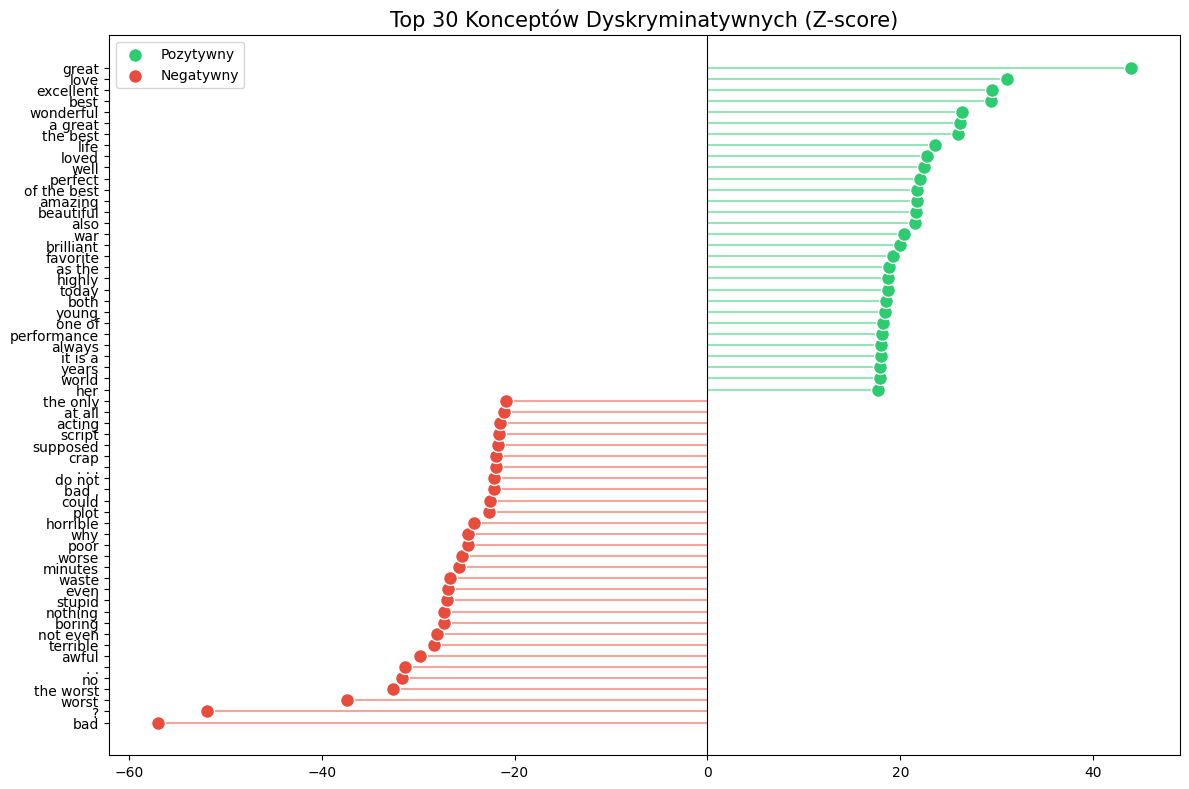

Building WordCloud clusters:   0%|          | 0/29749 [00:00<?, ?it/s]

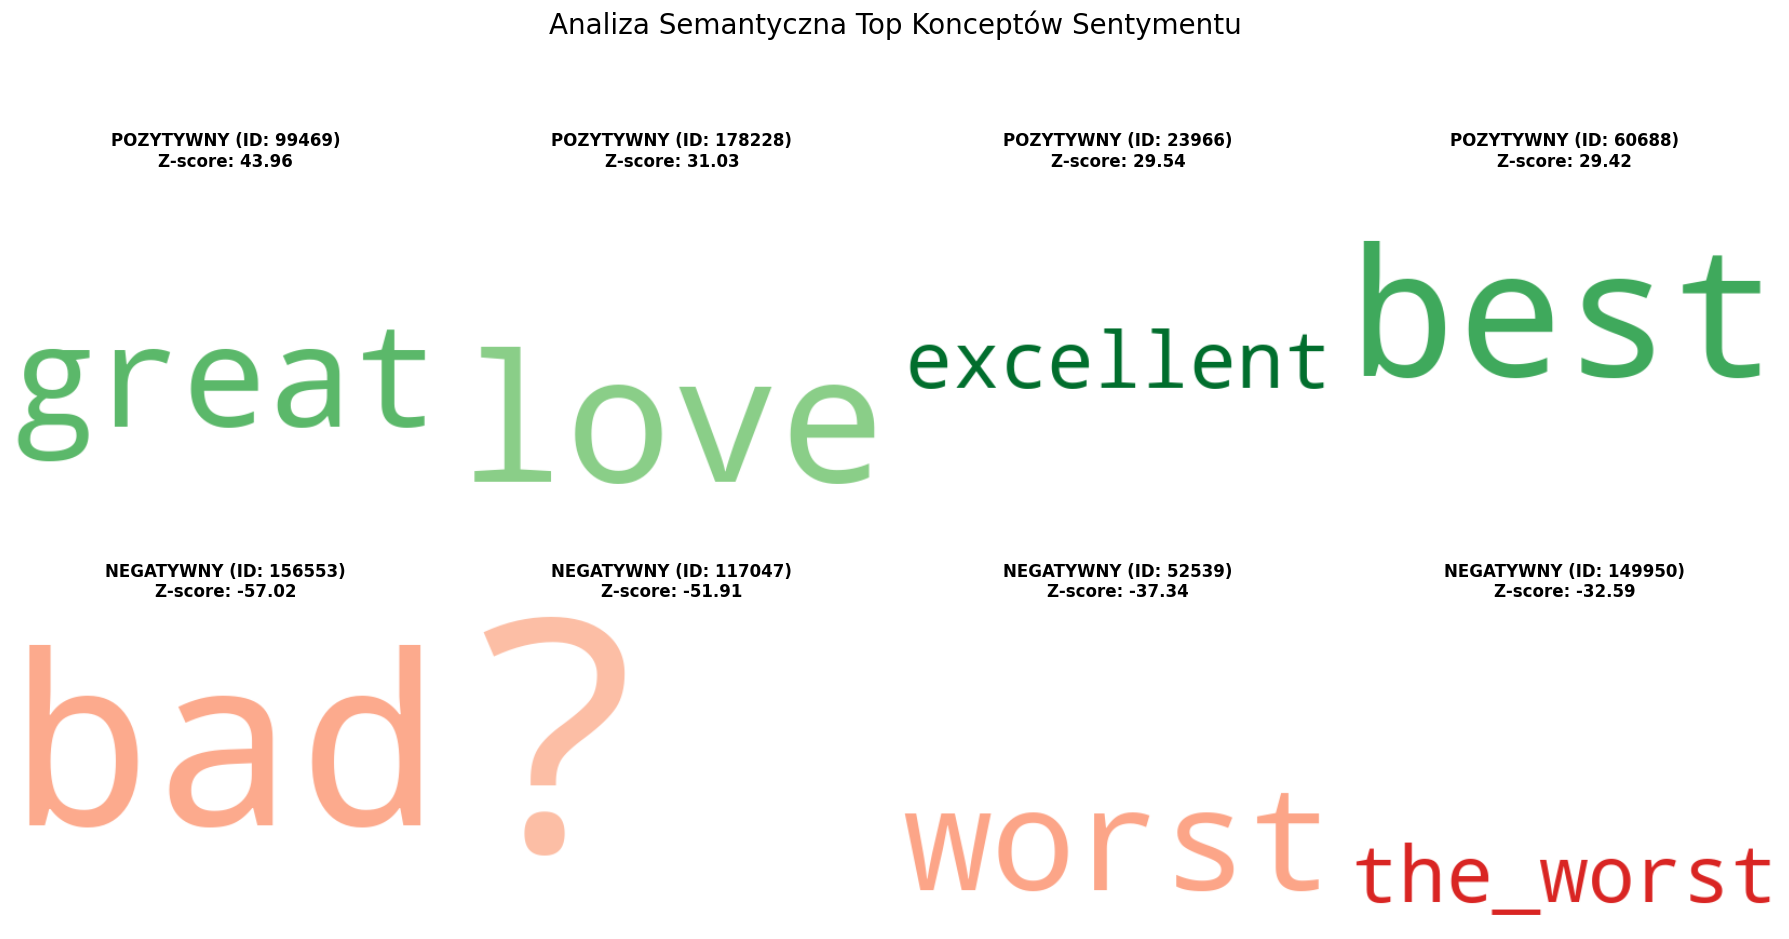

In [14]:
# 4. Visualization: Top Discriminative Concepts
from src.utils.visualizer import ModelVisualizer
concept_units = {i: u for u, i in train_map.items()}
ModelVisualizer.plot_top_concepts(sf, concept_units, top_n=30)
ModelVisualizer.plot_sentiment_wordclouds(train, train_map, unique_units, sf, n_gram_range=N_GRAM_RANGE)

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
])

X_train = pipeline.fit_transform(item['important_ids'] for item in train)
X_test = pipeline.transform(item['important_ids'] for item in test)
X_val = pipeline.transform(item['important_ids'] for item in val)

## SVM_BOC Evaluation

**Accuracy:** 0.9956

,precision,recall,f1-score,support
0,0.99588,0.99534,0.99561,14819
1,0.99538,0.99591,0.99565,14930
accuracy,0.99563,0.99563,0.99563,0
macro avg,0.99563,0.99563,0.99563,29749
weighted avg,0.99563,0.99563,0.99563,29749


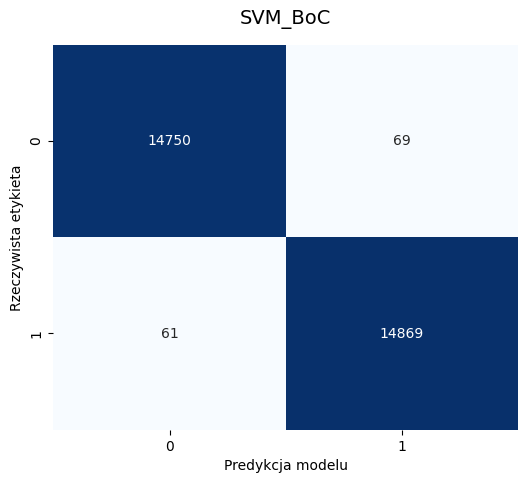

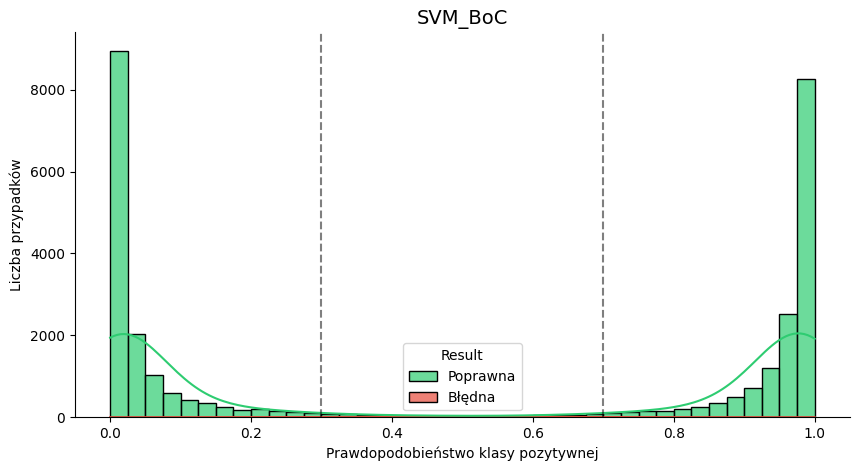

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,14563,14546,99.88,48.95
Certain Negative,14409,14398,99.92,48.44
Uncertain,777,675,86.87,2.61


## SVM_BOC Evaluation

**Accuracy:** 0.9123

,precision,recall,f1-score,support
0,0.91463,0.90870,0.91166,4940
1,0.90996,0.91581,0.91288,4977
accuracy,0.91227,0.91227,0.91227,0
macro avg,0.91230,0.91226,0.91227,9917
weighted avg,0.91229,0.91227,0.91227,9917


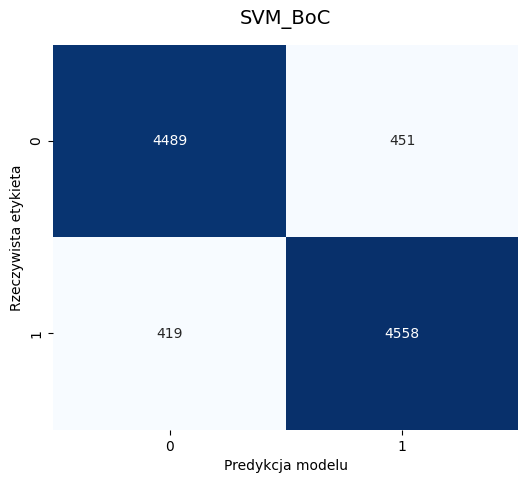

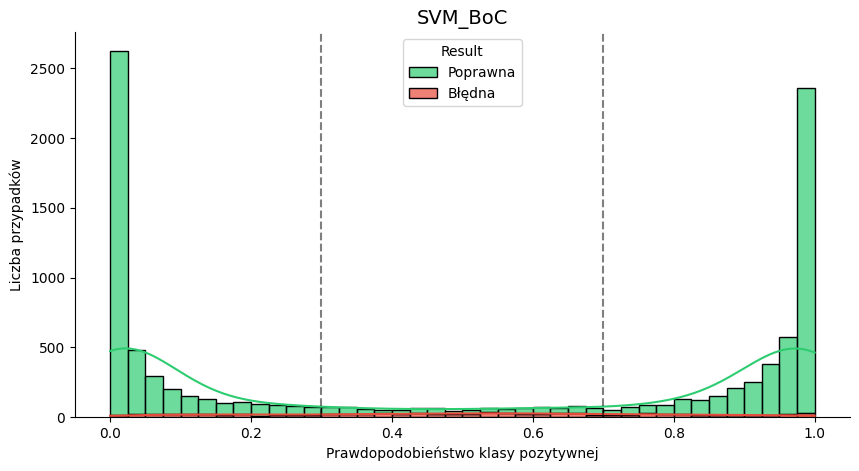

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,4485,4254,94.85,45.23
Certain Negative,4431,4202,94.83,44.68
Uncertain,1001,591,59.04,10.09


In [16]:
svm_model = LinearSVMClassifier(name="SVM_BoC")
svm_model.train(X_train, [item['sentiment'] for item in train])
svm_probs_train, svm_preds_train = svm_model.evaluate(X_train, [item['sentiment'] for item in train], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)
svm_probs_test, svm_preds_test = svm_model.evaluate(X_test, [item['sentiment'] for item in test], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)

In [17]:
for i, item in enumerate(train):
    item['pred'] = svm_preds_train[i]
    item['prob'] = svm_probs_train[i]

ModelVisualizer.display_extreme_errors(train)
ModelVisualizer.display_uncertain_errors(train)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,this is a great movie. I love the series on tv...,0,1,0.972870
1,I love the episode where Jim becomes the Green...,0,1,0.881832
2,"I went to see this 3 nights ago here in Cork, ...",0,1,0.859234
3,'Major Payne' is a film about a major who make...,0,1,0.838588
4,This movie was pure genius. John Waters is bri...,0,1,0.803259



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,Like the gentle giants that make up the latter...,1,0,0.156404
1,This flick is sterling example of the state of...,1,0,0.149588
2,This was Laurel and Hardy's last silent film f...,1,0,0.132124
3,**SPOILERS AHEAD** It is really unfortunate th...,1,0,0.086956
4,This low-budget erotic thriller that has some ...,1,0,0.061176



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,This has to be one of the all time greatest ho...,0,1,0.500852,0.000852
1,"Jack Frost 2, is probably the most cheesiest m...",1,0,0.497492,0.002508
2,"This movie had no parts that were hilarious, m...",1,0,0.493770,0.006230
3,This movie is the only movie to feature a scen...,1,0,0.493391,0.006609
4,"The movie actually has a fairly good story, bu...",1,0,0.491958,0.008042
5,I thought it was a New-York located movie: wro...,0,1,0.508700,0.008700
6,This is probably one of the worst movies ever ...,1,0,0.490441,0.009559
7,I saw this movie with hopes of a good laugh bu...,1,0,0.489195,0.010805
8,If you're looking for a not-so-serious mob mov...,1,0,0.488926,0.011074
9,When I first found out that Brian Krause was g...,1,0,0.487668,0.012332


In [18]:
for i, item in enumerate(test):
    item['pred'] = svm_preds_test[i]
    item['prob'] = svm_probs_test[i]

ModelVisualizer.display_extreme_errors(test)
ModelVisualizer.display_uncertain_errors(test)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,I enjoyed the beautiful scenery in this movie ...,0,1,0.998591
1,"This sleek, sexy movie is a must-see. Only upo...",0,1,0.998106
2,Totally forgettable movie but an unbelievable ...,0,1,0.998056
3,The story goes something like this: A small-to...,0,1,0.997940
4,I've almost forever been against the inclusion...,0,1,0.996407



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,In defense of this movie I must repeat what I ...,1,0,0.003414
1,I'm a HUGE fan of the twin sisters. Although t...,1,0,0.003256
2,If the creators of this film had made any atte...,1,0,0.002753
3,This movie has everything that makes a bad mov...,1,0,0.002263
4,This movie is stuffed full of stock Horror mov...,1,0,0.000440



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,Barry Kane (Robert Cummings) is wrongfully acc...,1,0,0.499929,0.000071
1,I saw Arthur(the TV series and the books)years...,0,1,0.500099,0.000099
2,"Back (again) in Scotland, Lassie is (again) on...",0,1,0.500171,0.000171
3,*** WARNING! SPOILERS CONTAINED HEREIN! *** Th...,0,1,0.500658,0.000658
4,"This Hal Roach comedy short, A Tough Winter, i...",0,1,0.501124,0.001124
5,"In this peculiar movie, the themes of the end ...",1,0,0.498117,0.001883
6,Although this film was made before Dogme emerg...,0,1,0.502294,0.002294
7,"This isn't among my favorite Hitchcock films, ...",1,0,0.497576,0.002424
8,"When I was 16 I saw the documentary: ""A Funny ...",0,1,0.502466,0.002466
9,This movie I've seen many times. I read the bo...,1,0,0.496881,0.003119


## LOGREG_BOC Evaluation

**Accuracy:** 0.9530

,precision,recall,f1-score,support
0,0.95909,0.94602,0.95251,14819
1,0.94713,0.95995,0.95350,14930
accuracy,0.95301,0.95301,0.95301,0
macro avg,0.95311,0.95298,0.95300,29749
weighted avg,0.95309,0.95301,0.95300,29749


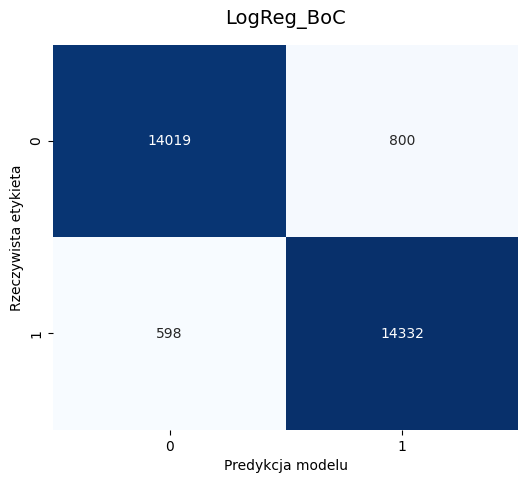

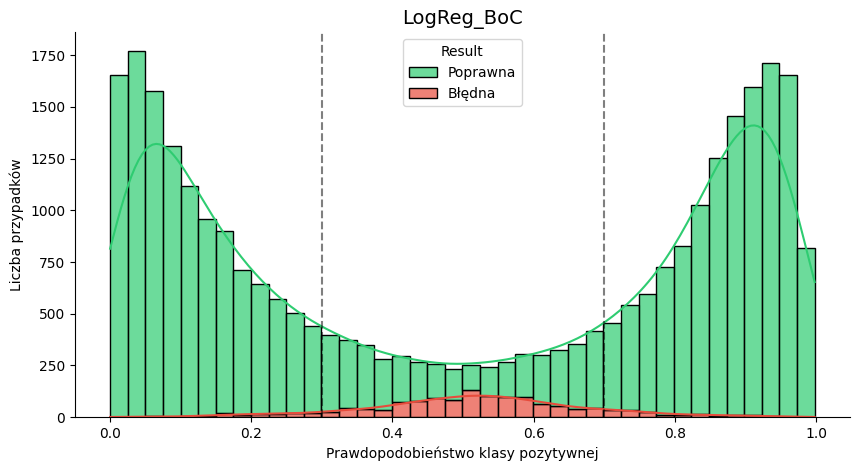

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,12650,12484,98.69,42.52
Certain Negative,12166,12046,99.01,40.90
Uncertain,4933,3821,77.46,16.58


## LOGREG_BOC Evaluation

**Accuracy:** 0.9116

,precision,recall,f1-score,support
0,0.91757,0.90364,0.91056,4940
1,0.90578,0.91943,0.91255,4977
accuracy,0.91157,0.91157,0.91157,0
macro avg,0.91168,0.91154,0.91155,9917
weighted avg,0.91166,0.91157,0.91156,9917


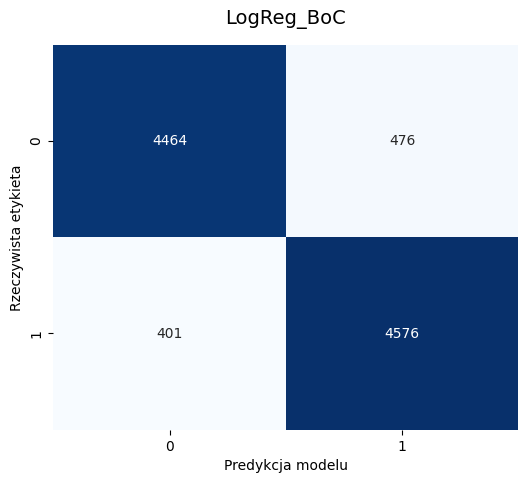

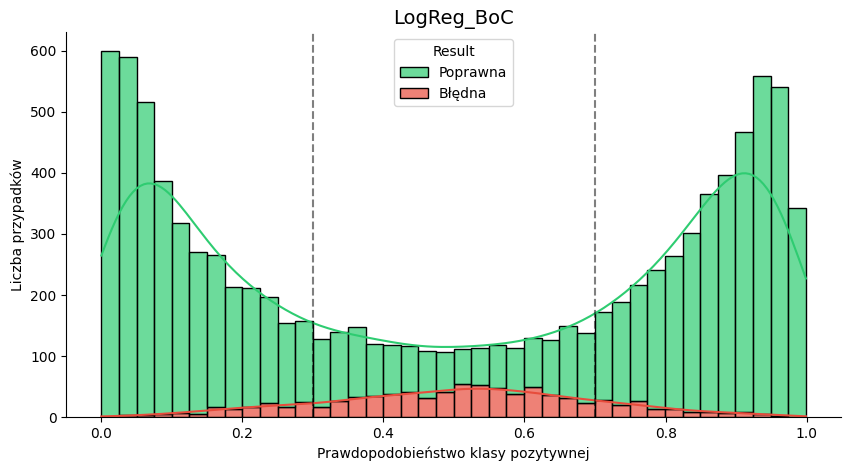

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,4048,3906,96.49,40.82
Certain Negative,3878,3742,96.49,39.10
Uncertain,1991,1392,69.91,20.08


In [19]:
# 3. Train and Evaluate Logistic Regression (Robustness check)
lr_model = LogisticRegressionClassifier(name="LogReg_BoC")
lr_model.train(X_train, [item['sentiment'] for item in train]) #
lr_probs_train, lr_preds_train = lr_model.evaluate(X_train, [item['sentiment'] for item in train], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)
lr_probs_test, lr_preds_test = lr_model.evaluate(X_test, [item['sentiment'] for item in test], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)

In [20]:
for i, item in enumerate(train):
    item['pred'] = lr_preds_train[i]
    item['prob'] = lr_probs_train[i]

ModelVisualizer.display_extreme_errors(train)
ModelVisualizer.display_uncertain_errors(train)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,this is a great movie. I love the series on tv...,0,1,0.994600
1,I love the episode where Jim becomes the Green...,0,1,0.958496
2,This is definitely one of the best Kung fu mov...,0,1,0.955029
3,'Ernest Saves Christmas' is comedian Ernest's ...,0,1,0.948433
4,'Major Payne' is a film about a major who make...,0,1,0.938352



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,I was really excited about seeing this film. I...,1,0,0.060808
1,Was this based on a comic-book? A video-game? ...,1,0,0.047811
2,**SPOILERS AHEAD** It is really unfortunate th...,1,0,0.025968
3,This flick is sterling example of the state of...,1,0,0.011289
4,This low-budget erotic thriller that has some ...,1,0,0.009988



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,"Okay, you have: Penelope Keith as Miss Herring...",0,1,0.500193,0.000193
1,I've heard a lot of different opinions about t...,1,0,0.499569,0.000431
2,The Ali G show was really something amazing - ...,1,0,0.499376,0.000624
3,This film is not at all as bad as some people ...,1,0,0.499299,0.000701
4,"Despite, or perhaps in part because of the cle...",0,1,0.500778,0.000778
5,We are not in the fairy tale of the naked empe...,0,1,0.500867,0.000867
6,In order to enjoy 'Fur - An imaginary portrait...,0,1,0.501137,0.001137
7,All of the reviews here about how much ZP lack...,1,0,0.498825,0.001175
8,"I love this movie, but the music at all the al...",1,0,0.498652,0.001348
9,This is the most depressing film I have ever s...,0,1,0.501414,0.001414


In [21]:
for i, item in enumerate(test):
    item['pred'] = lr_preds_test[i]
    item['prob'] = lr_probs_test[i]

ModelVisualizer.display_extreme_errors(test)
ModelVisualizer.display_uncertain_errors(test)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,I enjoyed the beautiful scenery in this movie ...,0,1,0.976101
1,I have an affection for these twists on Britis...,0,1,0.954199
2,this one of the best celebrity's reality shows...,0,1,0.951962
3,Totally forgettable movie but an unbelievable ...,0,1,0.944296
4,"This sleek, sexy movie is a must-see. Only upo...",0,1,0.939762



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,In defense of this movie I must repeat what I ...,1,0,0.057735
1,"Man, if anyone was expecting a great zombie mo...",1,0,0.039134
2,If the creators of this film had made any atte...,1,0,0.036353
3,This movie is stuffed full of stock Horror mov...,1,0,0.028920
4,This movie has everything that makes a bad mov...,1,0,0.020799



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,Although normally my preference is not for rom...,0,1,0.500045,0.000045
1,The movie may be great. I just watched it last...,1,0,0.499860,0.000140
2,Mary Pickford becomes the chieftain of a Scott...,0,1,0.500220,0.000220
3,Another variation and improvisation on the fam...,0,1,0.500411,0.000411
4,As a father of four in his forties I thought t...,1,0,0.499510,0.000490
5,"Well, this was one of those films I caught on ...",1,0,0.499275,0.000725
6,While the new Pride & Prejudice film is gorgeo...,0,1,0.500792,0.000792
7,This movie is without a doubt a perfect 10/10....,1,0,0.498677,0.001323
8,"""Sex and the City"" has some great things going...",0,1,0.501469,0.001469
9,Okay. To enjoy this silent comedy short you MU...,1,0,0.498420,0.001580


In [22]:
from src.models.deep import BERTClassifier

# --- STAGE 1: Train on FULL Training Data ---
bert_model = BERTClassifier(name="BERT_Refiner")
bert_model.train(
    X_text=[item['clean_review'] for item in train],
    y=[item['sentiment'] for item in train],
    epochs=3,
    batch_size=16
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Epoch 1/3


2026-01-02 23:34:32.062792: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ad46c5de5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-02 23:34:32.062824: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2026-01-02 23:34:32.088083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-02 23:34:32.128010: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1767393272.232707   34318 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1488/1488 [==============================] - 294s 184ms/step - loss: 0.3230 - accuracy: 0.8589 - val_loss: 0.2836 - val_accuracy: 0.8790 - lr: 2.0000e-05
Epoch 2/3
1488/1488 [==============================] - 282s 189ms/step - loss: 0.2081 - accuracy: 0.9170 - val_loss: 0.2874 - val_accuracy: 0.8829 - lr: 2.0000e-05
Epoch 3/3
1488/1488 [==============================] - 290s 195ms/step - loss: 0.0724 - accuracy: 0.9755 - val_loss: 0.3936 - val_accuracy: 0.8824 - lr: 4.0000e-06


Identified 1001 low-confidence samples for refinement.


## BERT_REFINER Evaluation

**Accuracy:** 0.7133

,precision,recall,f1-score,support
0,0.74444,0.66075,0.70010,507
1,0.68784,0.76721,0.72536,494
accuracy,0.71329,0.71329,0.71329,0
macro avg,0.71614,0.71398,0.71273,1001
weighted avg,0.71651,0.71329,0.71257,1001


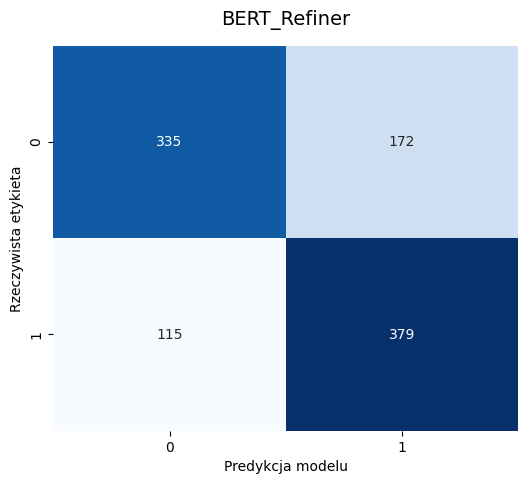

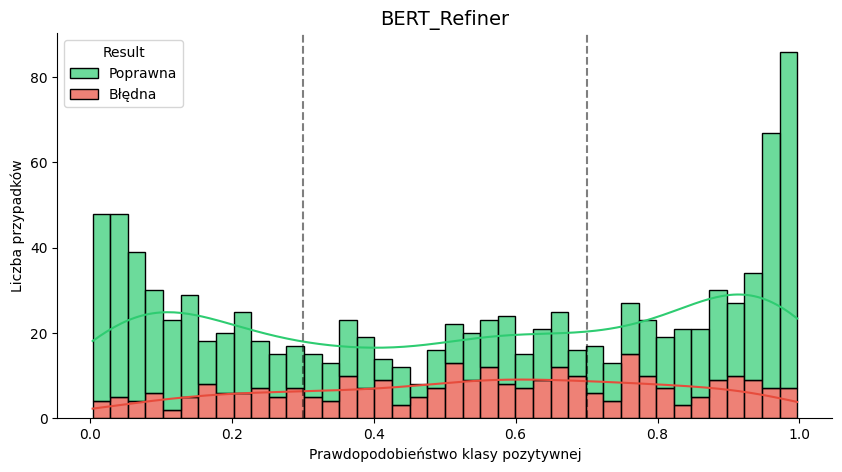

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,385,293,76.10,38.46
Certain Negative,330,265,80.30,32.97
Uncertain,286,156,54.55,28.57


In [23]:
# --- STAGE 2: Identify Unsure Samples from SVM ---
uncertain_mask = np.abs(svm_probs_test - 0.5) < 0.5 - LOWER_CONFIDENCE_THRESHOLD
test_low_conf = [test[i] for i, is_uncertain in enumerate(uncertain_mask) if is_uncertain]
print(f"Identified {len(test_low_conf)} low-confidence samples for refinement.")

# 1. Prepare data for BERT (Extracting from our filtered list of dictionaries)
X_refine = [item['clean_review'] for item in test_low_conf]
y_refine = [item['sentiment'] for item in test_low_conf]

# 2. Initial evaluation on these difficult samples before refinement
bert_prob_basic, bert_pred_basic = bert_model.evaluate(
    X_test=X_refine, 
    y_test=y_refine,
    lower_threshold=LOWER_CONFIDENCE_THRESHOLD
)

Starting Stage 2: Targeted Refinement...
Froze the first 4 layers of BERT.
Epoch 1/5
200/200 [==============================] - 31s 116ms/step - loss: 0.5776 - accuracy: 0.7013 - val_loss: 0.5167 - val_accuracy: 0.7313 - lr: 5.0000e-06
Epoch 2/5
200/200 [==============================] - 17s 86ms/step - loss: 0.5405 - accuracy: 0.7212 - val_loss: 0.5144 - val_accuracy: 0.7214 - lr: 5.0000e-06
Epoch 3/5
200/200 [==============================] - 14s 71ms/step - loss: 0.5216 - accuracy: 0.7400 - val_loss: 0.5137 - val_accuracy: 0.7214 - lr: 5.0000e-06
Epoch 4/5
200/200 [==============================] - 16s 79ms/step - loss: 0.5011 - accuracy: 0.7400 - val_loss: 0.5188 - val_accuracy: 0.7463 - lr: 5.0000e-06
Epoch 5/5
200/200 [==============================] - 14s 72ms/step - loss: 0.4748 - accuracy: 0.7713 - val_loss: 0.5188 - val_accuracy: 0.7363 - lr: 1.0000e-06


## BERT_REFINER Evaluation

**Accuracy:** 0.7522

,precision,recall,f1-score,support
0,0.75442,0.75740,0.75591,507
1,0.75000,0.74696,0.74848,494
accuracy,0.75225,0.75225,0.75225,0
macro avg,0.75221,0.75218,0.75219,1001
weighted avg,0.75224,0.75225,0.75224,1001


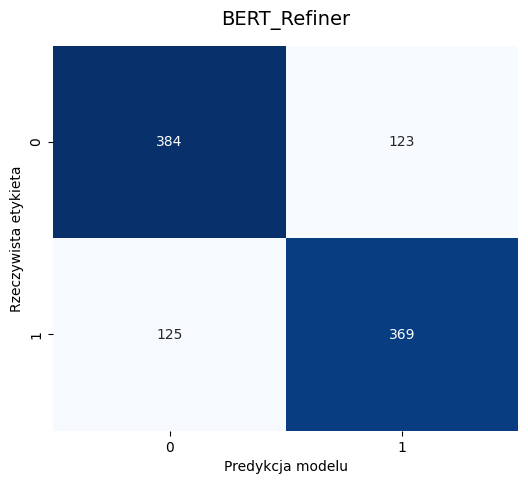

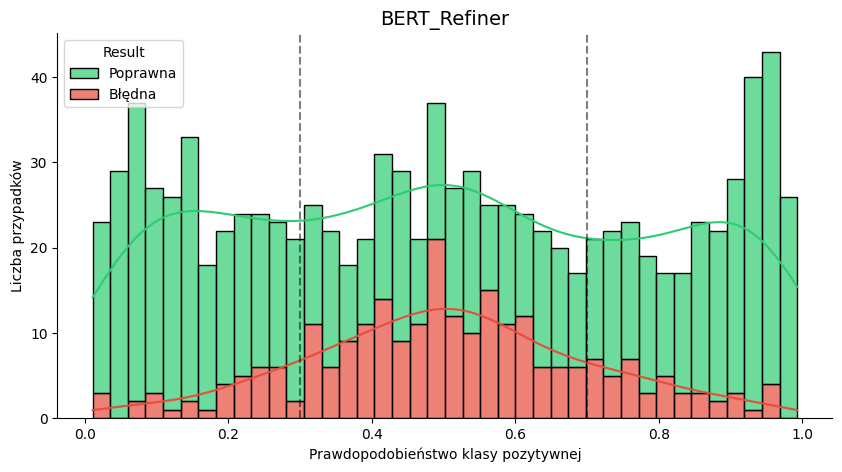

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,297,255,85.86,29.67
Certain Negative,304,269,88.49,30.37
Uncertain,400,229,57.25,39.96


In [24]:
# --- STAGE 3: Specialized Fine-Tuning (Refinement) ---
print("Starting Stage 2: Targeted Refinement...")

bert_model.freeze_backbone(num_layers_to_freeze=4) 

bert_model.train(
    X_text=X_refine, 
    y=y_refine,
    epochs=5,
    batch_size=4,   # Small batch for difficult samples
    lr=5e-6         # Extremely low LR: $5 \times 10^{-6}$
)

bert_prob_specialized, bert_pred_specialized = bert_model.evaluate(
    X_test=X_refine, 
    y_test=y_refine,
    lower_threshold=LOWER_CONFIDENCE_THRESHOLD
)

In [25]:
for i, item in enumerate(test_low_conf):
    item['pred'] = bert_pred_specialized[i]
    item['prob'] = bert_prob_specialized[i]

ModelVisualizer.display_extreme_errors(test_low_conf)
ModelVisualizer.display_uncertain_errors(test_low_conf)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,Although this film was made before Dogme emerg...,0,1,0.961201
1,A friend told me of John Fante last summer aft...,0,1,0.958163
2,Terrible. The only way I could even begin to c...,0,1,0.953047
3,It's a good movie if you plan to watch lots of...,0,1,0.952586
4,For those of you who've never heard of it (or ...,0,1,0.921659



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,Reviewed at the World Premiere screening Sept....,1,0,0.072042
1,Every time I watch this show I just want to tu...,1,0,0.061821
2,Obviously made on the cheap to capitalize on t...,1,0,0.028120
3,"By mistake, I ordered a series from the BBC, t...",1,0,0.022552
4,"""Slaughter High"" is a totally ridiculous slash...",1,0,0.020690



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,"An interesting idea for a film, both showing t...",0,1,0.500590,0.000590
1,"As is the case with many films of this ilk, my...",1,0,0.499258,0.000742
2,Dreamy young Ashton Kutcher (as Tom Stansfield...,0,1,0.500950,0.000950
3,The movie was a big Car Commercial. :-) But wh...,1,0,0.497847,0.002153
4,Cleopatra (the delicious Monica Bellucci) is c...,1,0,0.497605,0.002395
5,Barney and friends...the Dora the explorer of ...,0,1,0.504040,0.004040
6,The person's comment that said that Pat Robert...,1,0,0.495805,0.004195
7,I remember Devil Dog playing on TBS almost 20 ...,0,1,0.505273,0.005273
8,I had seen Rik Mayall in Blackadder and the Ne...,0,1,0.506498,0.006498
9,"In a poor village in Mexico, the Colonel (Fern...",1,0,0.492467,0.007533


In [26]:
from src.models.ensemble import EnsembleClassifier
models_dict = {"coarse": svm_model, "fine": bert_model}
ensemble = EnsembleClassifier(models_dict, threshold=1-LOWER_CONFIDENCE_THRESHOLD)

## ENSEMBLE Evaluation

**Accuracy:** 0.9219

,precision,recall,f1-score,support
0,0.92631,0.91618,0.92121,4939
1,0.91771,0.92767,0.92266,4977
accuracy,0.92194,0.92194,0.92194,0
macro avg,0.92201,0.92192,0.92194,9916
weighted avg,0.92199,0.92194,0.92194,9916


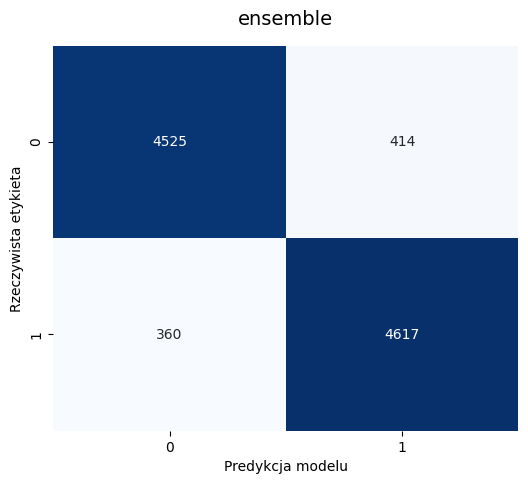

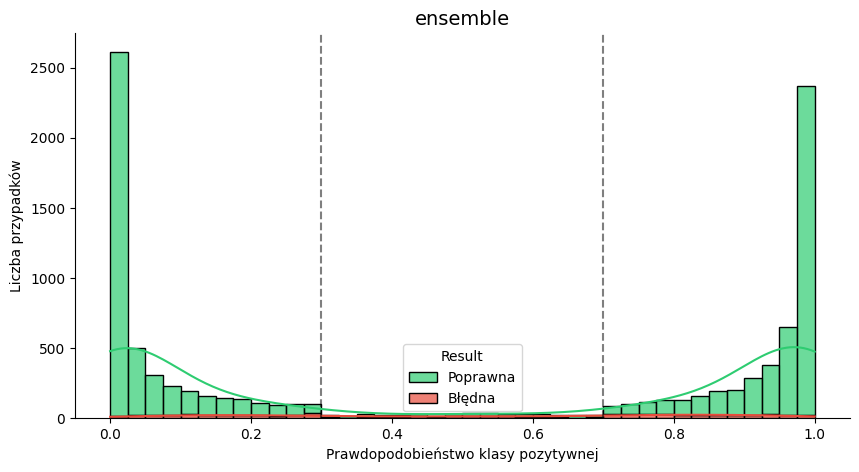

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,4798,4477,93.31,48.39
Certain Negative,4693,4419,94.16,47.33
Uncertain,425,246,57.88,4.29


In [36]:
X_sets_val = {"coarse": X_val, "fine": [item['clean_review'] for item in val]}
ensemble_probs_val, ensemble_preds_val = ensemble.evaluate(X_sets_val, [item['sentiment'] for item in val], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)

## SVM_BOC Evaluation

**Accuracy:** 0.9141

,precision,recall,f1-score,support
0,0.91628,0.91071,0.91348,4939
1,0.91192,0.91742,0.91466,4977
accuracy,0.91408,0.91408,0.91408,0
macro avg,0.91410,0.91407,0.91407,9916
weighted avg,0.91409,0.91408,0.91408,9916


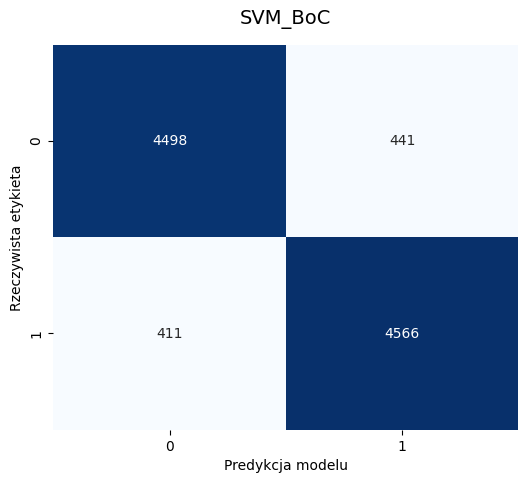

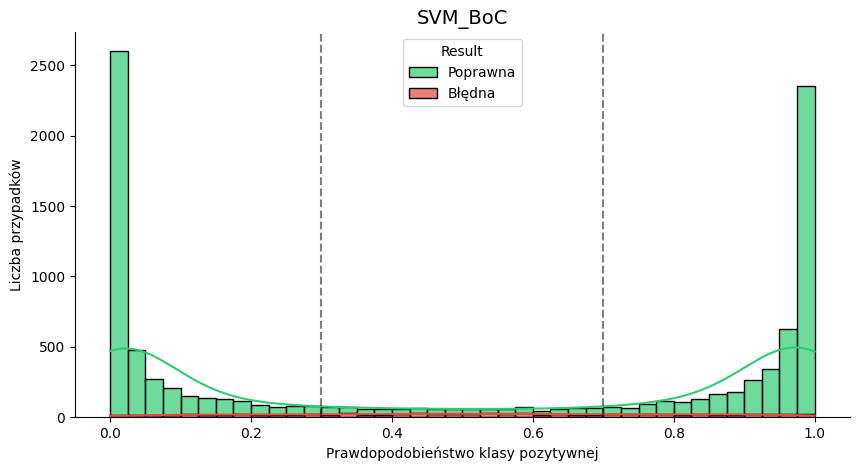

,Liczba_przypadkow,Poprawne,Accuracy (%),Coverage (%)
Category,,,,
Certain Positive,4526,4261,94.14,45.64
Certain Negative,4406,4181,94.89,44.43
Uncertain,984,622,63.21,9.92


In [34]:
svm_probs_val, svm_preds_val = svm_model.evaluate(X_val, [item['sentiment'] for item in val], lower_threshold=LOWER_CONFIDENCE_THRESHOLD)

In [31]:
import numpy as np
import hashlib
from scipy.sparse import csr_matrix

def sparse_row_hashes_fast(X: csr_matrix):
    """
    Compute a hash for each row of a CSR sparse matrix efficiently.
    """
    hashes = np.empty(X.shape[0], dtype=np.int64)
    indptr = X.indptr
    indices = X.indices
    data = X.data

    # Safer version of the loop inside your function
    for i in range(X.shape[0]):
        m = hashlib.md5()
        # Feed index and data arrays directly to md5
        m.update(indices[indptr[i]:indptr[i+1]].tobytes())
        m.update(np.round(data[indptr[i]:indptr[i+1]], 8).tobytes())
        hashes[i] = int(m.hexdigest(), 16) % (2**63)
    return hashes

# 1. Compute hashes for all three sets
train_hashes = sparse_row_hashes_fast(X_train)
val_hashes = sparse_row_hashes_fast(X_val)
test_hashes = sparse_row_hashes_fast(X_test)

# 2. Define sets for fast intersection lookups
train_set = set(train_hashes)
val_set = set(val_hashes)
test_set = set(test_hashes)

# 3. Check for overlaps
overlaps = {
    "Train <-> Validation": len(train_set.intersection(val_set)),
    "Train <-> Test": len(train_set.intersection(test_set)),
    "Validation <-> Test": len(val_set.intersection(test_set))
}

print("--- Dataset Integrity Check ---")
for comparison, count in overlaps.items():
    status = "MIXED" if count > 0 else "CLEAN"
    print(f"{comparison}: {count} common rows - {status}")

if any(v > 0 for v in overlaps.values()):
    print("\nWARNING: Some reviews are present in multiple sets. "
          "This might be due to original dataset duplicates or a split error.")
else:
    print("\nSUCCESS: All datasets are mutually exclusive.")

--- Dataset Integrity Check ---
Train <-> Validation: 0 common rows - CLEAN
Train <-> Test: 0 common rows - CLEAN
Validation <-> Test: 0 common rows - CLEAN

SUCCESS: All datasets are mutually exclusive.
